# Feature Engineering

In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os

## Loading Data

In [2]:
# load the data
def load_data(data_dir):
    all_files = glob(os.path.join(data_dir, "boxing_data_*.csv"))
    dataframes = {}
    for file in all_files:
        df = pd.read_csv(file)
        movement_type = file.split("_")[-3]
        df['movement_type'] = movement_type
        file_name = os.path.basename(file)
        dataframes[file_name] = df
    return dataframes

In [3]:
data_dir = '../data/processed'
dfs = load_data(data_dir)

# display basic information about the datasets before cleaning
for file_name, df in dfs.items():
    print(f"File: {file_name}")
    print(df.info())
    print(df.head())
    print(df.describe())
    
    print("\n" + "="*50 + "\n")

File: boxing_data_cross_20241002_190731.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7768 entries, 0 to 7767
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           7768 non-null   int64  
 1   timestamp       7768 non-null   float64
 2   movement_type   7768 non-null   object 
 3   left_shoulder   7768 non-null   object 
 4   right_shoulder  7768 non-null   object 
 5   left_elbow      7768 non-null   object 
 6   right_elbow     7768 non-null   object 
 7   left_wrist      7768 non-null   object 
 8   right_wrist     7768 non-null   object 
 9   left_hip        7768 non-null   object 
 10  right_hip       7768 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 667.7+ KB
None
   frame  timestamp movement_type          left_shoulder  \
0      0      0.000         cross  0.7521,0.2374,-1.9390   
1      1      0.017         cross  0.7521,0.2362,-2.0204   
2      2      0

## Data Cleaning Functions

In [4]:
def drop_zero_coords(df, columns):
    """drop any row where the x,y,z coordinates are all 0"""
    zero_condition = (df[columns] == 0).all(axis=1)
    return df[~zero_condition]

In [5]:
def remove_outliers(df, columns, n_std=3):
    """Remove outliers that are n standard deviations away from the mean."""
    
    # Remove duplicate columns, if any
    df = df.loc[:, ~df.columns.duplicated()]
    
    for col in columns:
        if col not in df.columns:
            print(f"Column {col} not found in the DataFrame.")
            continue
        
        mean = df[col].mean()
        std = df[col].std()
        
        if std == 0:  # If standard deviation is zero, all values are the same
            print(f"Standard deviation for {col} is 0, skipping this column.")
            continue
        
        # Update the mask for each column to keep rows within the bounds
        df = df[(df[col] <= mean + (n_std * std)) & (df[col] >= mean - (n_std * std))]
    
    return df


In [6]:
def interpolate_missing_values(df):
    """Interpolate missing values using linear interpolation"""
    return df.interpolate(method='linear', limit_direction='both')

In [7]:
def smooth_trajectories(df, columns, window = 5):
    """Apply moving average smoothing to specified columns"""
    for col in columns:
        df[col] = df[col].rolling(window=window, center=True).mean()
        
    # drop rows where NaN values are introduced due to the rolling window
    df = df.dropna(subset=columns)
    return df

## Feature Engineering Functions

In [8]:
def extract_coordinates(df, column):
    """Extract x, y, z coordinates from a column."""
    coords = df[column].str.split(',', expand=True).astype(float)
    
    if coords.shape[1] != 3:
        print(f"Warning {column} doesn't contain valid coordinate data")
        return pd.DataFrame()
    
    coords.columns = [f'{column}_x', f'{column}_y', f'{column}_z']
    return coords

for file_name, df in dfs.items():
    for landmark in ['left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip']:
        extracted_coords = extract_coordinates(df, landmark)
        
        if not extracted_coords.empty:
            df = pd.concat([df, extracted_coords], axis=1)
            
    dfs[file_name] = df
    print(f"Columns in {file_name}: {df.columns}")

Columns in boxing_data_cross_20241002_190731.csv: Index(['frame', 'timestamp', 'movement_type', 'left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_hip', 'right_hip', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y',
       'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z'],
      dtype='object')
Columns in boxing_data_jab_20241002_190259.csv: Index(['frame', 'timestamp', 'movement_type', 'left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_hip', 'right_hip', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder

In [9]:
def calculate_joint_angle(df, joint, proximal, distal):
    """Calculate the angle at a joint given proximal and distal points"""
    v1 = df[[f'{proximal}_x', f'{proximal}_y', f'{proximal}_z']].values - df[[f'{joint}_x', f'{joint}_y', f'{joint}_z']].values
    v2 = df[[f'{distal}_x', f'{distal}_y', f'{distal}_z']].values - df[[f'{joint}_x', f'{joint}_y', f'{joint}_z']].values
    
    v1_mag = np.linalg.norm(v1, axis=1)
    v2_mag = np.linalg.norm(v2, axis=1)
    
    # Avoid division by zero
    valid_magnitudes = (v1_mag != 0) & (v2_mag != 0)
    
    cos_angle = np.zeros(len(df))
    cos_angle[valid_magnitudes] = np.sum(v1[valid_magnitudes] * v2[valid_magnitudes], axis=1) / (v1_mag[valid_magnitudes] * v2_mag[valid_magnitudes])
    
    # Clip cos_angle to [-1, 1] to avoid invalid input to arccos
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    
    angle = np.degrees(np.arccos(cos_angle))
    
    # Set angle to 0 for invalid magnitudes
    angle[~valid_magnitudes] = 0
    
    return angle

## Main Processing Pipeline
- Step 1: Data Cleaning
- Step 2: Feature Engineering

In [10]:
def process_dataframe(df):
    print("Original DataFrame", df.head())
    # Data Cleaning
    coordinate_columns = [col for col in df.columns if col in ['left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip']]
    
    for col in coordinate_columns:
        df = pd.concat([df, extract_coordinates(df, col)], axis=1)
        
    print("After extracting coordinates", df.head())
        
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    zero_coordinate_columns = [f'{col}_x' for col in coordinate_columns] + [f'{col}_y' for col in coordinate_columns] + [f'{col}_z' for col in coordinate_columns]
    
    df = drop_zero_coords(df, zero_coordinate_columns)
    print("After dropping zero coordinates", df.head())
    
    df = remove_outliers(df, numeric_columns)
    print("After removing outliers", df.head())
    df = interpolate_missing_values(df)
    print("After interpolating missing values", df.head())
    
    df = smooth_trajectories(df, numeric_columns)
    print("Original DataFrame", df.head())
    
    # Feature Engineering
    df['right_elbow_angle'] = calculate_joint_angle(df, 'right_elbow', 'right_shoulder', 'right_wrist')
    df['left_elbow_angle'] = calculate_joint_angle(df, 'left_elbow', 'left_shoulder', 'left_wrist')
    df['right_shoulder_angle'] = calculate_joint_angle(df, 'right_shoulder', 'right_hip', 'right_elbow')
    df['left_shoulder_angle'] = calculate_joint_angle(df, 'left_shoulder', 'left_hip', 'left_elbow')
    
    return df

## Process All Dataframes

In [11]:
cleaned_dfs = {}
for file_name, df in dfs.items():
    print(df.describe())
    print(f"Processing {file_name}...")
    cleaned_dfs[file_name] = process_dataframe(df)
    print(f"Finished processing {file_name}")
    
for file_name, cleaned_df in cleaned_dfs.items():
    print(f"Summary Statistics for {file_name}:")
    print(cleaned_df.describe())

             frame    timestamp  left_shoulder_x  left_shoulder_y  \
count  7768.000000  7768.000000      7768.000000      7768.000000   
mean   3883.500000    64.728333         0.522674         0.447159   
std    2242.572778    37.378140         0.075959         0.057261   
min       0.000000     0.000000         0.000000        -0.028900   
25%    1941.750000    32.364000         0.492475         0.443275   
50%    3883.500000    64.728500         0.527700         0.459000   
75%    5825.250000    97.092250         0.564800         0.468400   
max    7767.000000   129.457000         0.793700         0.864900   

       left_shoulder_z  right_shoulder_x  right_shoulder_y  right_shoulder_z  \
count      7768.000000       7768.000000       7768.000000       7768.000000   
mean          0.051553          0.349877          0.442375         -0.026494   
std           0.163534          0.065538          0.057343          0.130270   
min          -2.161500          0.000000          0.000000

After removing outliers      frame  timestamp movement_type         left_shoulder  \
124    124      2.067         cross  0.5895,0.4148,0.0510   
125    125      2.083         cross  0.5896,0.4183,0.0586   
126    126      2.100         cross  0.5894,0.4221,0.0589   
127    127      2.117         cross  0.5895,0.4271,0.0600   
128    128      2.133         cross  0.5897,0.4306,0.0930   

            right_shoulder             left_elbow            right_elbow  \
124  0.3814,0.4218,-0.0323  0.6262,0.5083,-0.2071  0.3511,0.5232,-0.2831   
125  0.3843,0.4235,-0.0267  0.6279,0.5098,-0.1750  0.3508,0.5245,-0.2748   
126  0.3868,0.4256,-0.0649  0.6290,0.5146,-0.1595  0.3513,0.5256,-0.3001   
127  0.3880,0.4273,-0.0545  0.6291,0.5180,-0.1710  0.3513,0.5266,-0.2690   
128  0.3902,0.4293,-0.0450  0.6292,0.5233,-0.1528  0.3516,0.5272,-0.2817   

                left_wrist            right_wrist              left_hip  ...  \
124  0.5937,0.4345,-0.6353  0.3798,0.4844,-0.6893  0.5782,0.6187,0.0440 

After extracting coordinates    frame  timestamp movement_type left_shoulder right_shoulder left_elbow  \
0      0      0.000           jab         0,0,0          0,0,0      0,0,0   
1      1      0.017           jab         0,0,0          0,0,0      0,0,0   
2      2      0.033           jab         0,0,0          0,0,0      0,0,0   
3      3      0.050           jab         0,0,0          0,0,0      0,0,0   
4      4      0.067           jab         0,0,0          0,0,0      0,0,0   

  right_elbow left_wrist right_wrist left_hip  ... left_wrist_z  \
0       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
1       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
2       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
3       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
4       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   

   right_wrist_x  right_wrist_y  right_wrist_z  left_hip_x  left_hip_y  \
0            0.0            0.0

Finished processing boxing_data_jab_20241002_190259.csv
             frame   timestamp  left_shoulder_x  left_shoulder_y  \
count  8463.000000  8463.00000      8463.000000      8463.000000   
mean   4231.000000    70.52000         0.518370         0.447391   
std    2443.201997    40.72196         0.067552         0.060979   
min       0.000000     0.00000         0.000000        -0.193000   
25%    2115.500000    35.26000         0.500550         0.445200   
50%    4231.000000    70.52000         0.525200         0.458200   
75%    6346.500000   105.78000         0.544650         0.468200   
max    8462.000000   141.04000         0.964500         0.944800   

       left_shoulder_z  right_shoulder_x  right_shoulder_y  right_shoulder_z  \
count      8463.000000       8463.000000       8463.000000       8463.000000   
mean          0.090074          0.348787          0.435377         -0.016625   
std           0.114779          0.063072          0.059820          0.075285   
min        

             frame    timestamp  left_shoulder_x  left_shoulder_y  \
count  7569.000000  7569.000000      7569.000000      7569.000000   
mean   3784.000000    63.069999         0.562438         0.506957   
std    2185.126427    36.420701         0.072088         0.067167   
min       0.000000     0.000000        -0.110500         0.000000   
25%    1892.000000    31.535000         0.543700         0.511900   
50%    3784.000000    63.070000         0.566000         0.519100   
75%    5676.000000    94.605000         0.594000         0.526700   
max    7568.000000   126.140000         0.746000         0.971600   

       left_shoulder_z  right_shoulder_x  right_shoulder_y  right_shoulder_z  \
count      7569.000000       7569.000000       7569.000000       7569.000000   
mean          0.059340          0.391007          0.507371          0.016274   
std           0.074543          0.059714          0.067570          0.068670   
min          -1.952300         -0.241300          0.000000

After removing outliers      frame  timestamp  movement_type         left_shoulder  \
154    154      2.567  left-uppercut  0.5429,0.5004,0.0297   
155    155      2.583  left-uppercut  0.5434,0.5025,0.0303   
156    156      2.600  left-uppercut  0.5456,0.5040,0.0210   
157    157      2.617  left-uppercut  0.5473,0.5064,0.0098   
158    158      2.633  left-uppercut  0.5476,0.5076,0.0176   

           right_shoulder             left_elbow            right_elbow  \
154  0.3529,0.5033,0.0489  0.5727,0.5913,-0.1429  0.3052,0.5923,-0.1219   
155  0.3546,0.5055,0.0439  0.5727,0.5921,-0.1393  0.3059,0.5955,-0.1164   
156  0.3567,0.5073,0.0402  0.5731,0.5931,-0.1434  0.3074,0.5969,-0.1188   
157  0.3599,0.5094,0.0298  0.5732,0.5952,-0.1640  0.3101,0.5972,-0.1438   
158  0.3614,0.5105,0.0294  0.5732,0.5960,-0.1506  0.3147,0.5984,-0.1384   

                left_wrist            right_wrist              left_hip  ...  \
154  0.5372,0.5239,-0.3803  0.3422,0.5424,-0.3999  0.5273,0.6920,0.0041 

After extracting coordinates    frame  timestamp movement_type left_shoulder right_shoulder left_elbow  \
0      0      0.000    no-punches         0,0,0          0,0,0      0,0,0   
1      1      0.017    no-punches         0,0,0          0,0,0      0,0,0   
2      2      0.033    no-punches         0,0,0          0,0,0      0,0,0   
3      3      0.050    no-punches         0,0,0          0,0,0      0,0,0   
4      4      0.067    no-punches         0,0,0          0,0,0      0,0,0   

  right_elbow left_wrist right_wrist left_hip  ... left_wrist_z  \
0       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
1       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
2       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
3       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
4       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   

   right_wrist_x  right_wrist_y  right_wrist_z  left_hip_x  left_hip_y  \
0            0.0            0.0

             frame    timestamp  left_shoulder_x  left_shoulder_y  \
count  7959.000000  7959.000000       7959.00000      7959.000000   
mean   3979.000000    66.320000          0.49232         0.511170   
std    2297.709729    38.297089          0.08163         0.065543   
min       0.000000     0.000000         -0.13780         0.000000   
25%    1989.500000    33.160000          0.45650         0.508000   
50%    3979.000000    66.320000          0.50080         0.526200   
75%    5968.500000    99.480000          0.53090         0.536300   
max    7958.000000   132.640000          0.77560         0.782200   

       left_shoulder_z  right_shoulder_x  right_shoulder_y  right_shoulder_z  \
count      7959.000000       7959.000000       7959.000000       7959.000000   
mean          0.070026          0.329199          0.511242          0.044634   
std           0.068568          0.060283          0.064285          0.069997   
min          -0.956900          0.000000          0.000000

After removing outliers      frame  timestamp movement_type         left_shoulder  \
165    165      2.750    right-hook  0.5933,0.5094,0.1056   
166    166      2.767    right-hook  0.5933,0.5113,0.1261   
167    167      2.783    right-hook  0.5933,0.5135,0.1293   
168    168      2.800    right-hook  0.5934,0.5153,0.1417   
169    169      2.817    right-hook  0.5936,0.5178,0.1414   

            right_shoulder             left_elbow            right_elbow  \
165  0.4268,0.4904,-0.0228  0.6162,0.5934,-0.1402  0.3494,0.5582,-0.2868   
166  0.4279,0.4925,-0.0352  0.6157,0.5954,-0.1186  0.3507,0.5642,-0.2972   
167  0.4287,0.4949,-0.0414  0.6160,0.5966,-0.1129  0.3513,0.5696,-0.2930   
168  0.4293,0.4977,-0.0307  0.6160,0.5989,-0.1003  0.3532,0.5725,-0.2918   
169  0.4310,0.5019,-0.0256  0.6162,0.6005,-0.0944  0.3557,0.5755,-0.2812   

                left_wrist            right_wrist              left_hip  ...  \
165  0.6111,0.5165,-0.4861  0.4285,0.4992,-0.5650  0.5402,0.6874,0.0639 

After extracting coordinates    frame  timestamp   movement_type left_shoulder right_shoulder left_elbow  \
0      0      0.000  right-uppercut         0,0,0          0,0,0      0,0,0   
1      1      0.017  right-uppercut         0,0,0          0,0,0      0,0,0   
2      2      0.033  right-uppercut         0,0,0          0,0,0      0,0,0   
3      3      0.050  right-uppercut         0,0,0          0,0,0      0,0,0   
4      4      0.067  right-uppercut         0,0,0          0,0,0      0,0,0   

  right_elbow left_wrist right_wrist left_hip  ... left_wrist_z  \
0       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
1       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
2       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
3       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   
4       0,0,0      0,0,0       0,0,0    0,0,0  ...          0.0   

   right_wrist_x  right_wrist_y  right_wrist_z  left_hip_x  left_hip_y  \
0            0.0   

             frame    timestamp  left_shoulder_x  left_shoulder_y  \
count  6001.000000  6001.000000      6001.000000      6001.000000   
mean   3780.751875    63.015778         0.534025         0.460596   
std    2182.838906    36.382519         0.044250         0.012701   
min     128.000000     2.133400         0.409964         0.417908   
25%    1865.000000    31.085000         0.503488         0.452900   
50%    3717.000000    61.953400         0.535176         0.462396   
75%    5757.000000    95.955000         0.568792         0.469892   
max    7574.000000   126.239800         0.639160         0.490004   

       left_shoulder_z  right_shoulder_x  right_shoulder_y  right_shoulder_z  \
count      6001.000000       6001.000000       6001.000000       6001.000000   
mean          0.069007          0.365134          0.452906         -0.022488   
std           0.034228          0.044147          0.011263          0.040138   
min          -0.027104          0.244564          0.422096

             frame    timestamp  left_shoulder_x  left_shoulder_y  \
count  6204.000000  6204.000000      6204.000000      6204.000000   
mean   3819.114926    63.655112         0.496056         0.528509   
std    2128.212014    35.471981         0.044697         0.014233   
min     169.000000     2.816600         0.356512         0.481976   
25%    1990.750000    33.180850         0.467597         0.521112   
50%    3724.500000    62.078000         0.501840         0.529964   
75%    5674.250000    94.575550         0.526280         0.538176   
max    7755.000000   129.256400         0.609260         0.558832   

       left_shoulder_z  right_shoulder_x  right_shoulder_y  right_shoulder_z  \
count      6204.000000       6204.000000       6204.000000       6204.000000   
mean          0.076925          0.336634          0.526676          0.031885   
std           0.032305          0.041930          0.010962          0.045673   
min          -0.024772          0.208936          0.488408

## Visualisation of Cleaned Data

Plotting for boxing_data_cross_20241002_190731.csv - Movement Type: cross


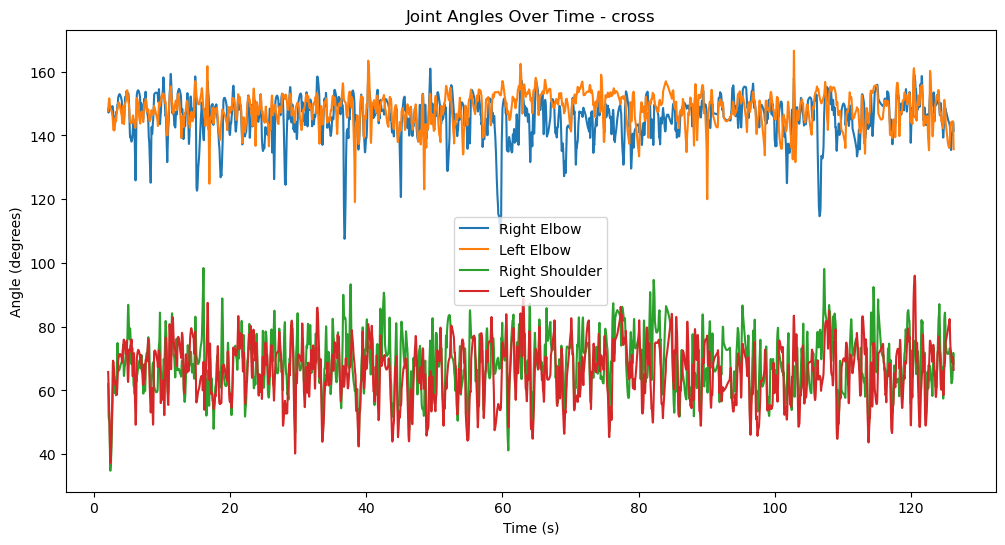

Plotting for boxing_data_jab_20241002_190259.csv - Movement Type: jab


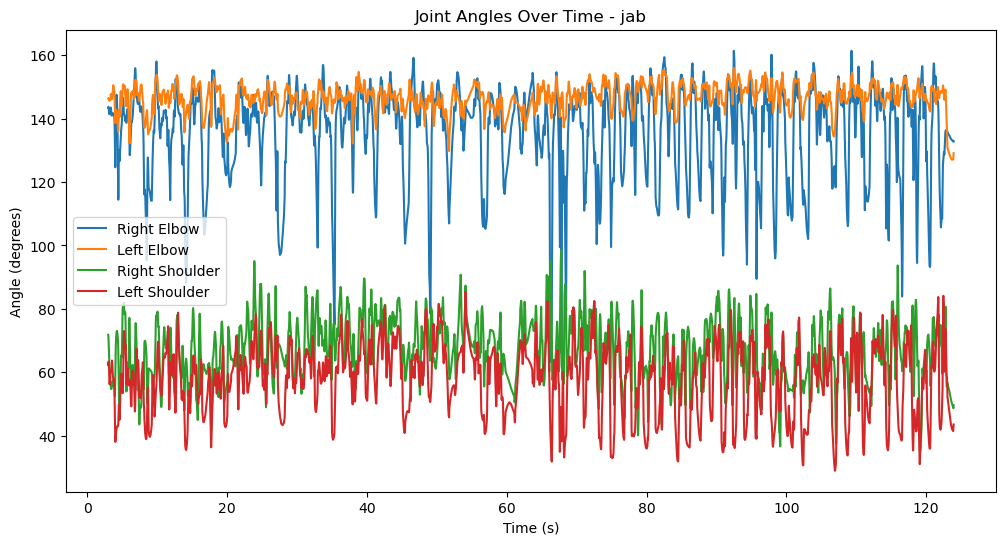

Plotting for boxing_data_left-hook_20241002_191201.csv - Movement Type: left-hook


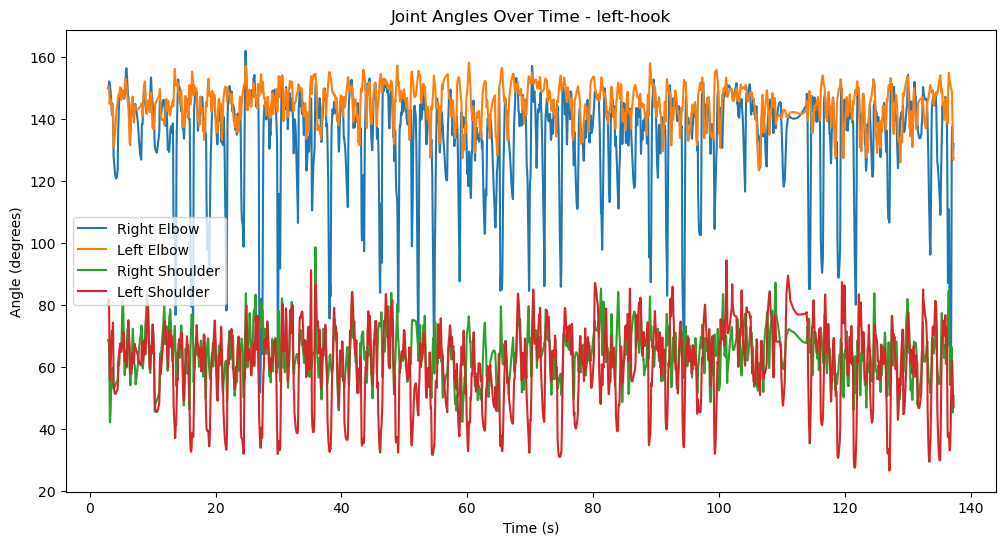

Plotting for boxing_data_left-uppercut_20241002_192142.csv - Movement Type: left-uppercut


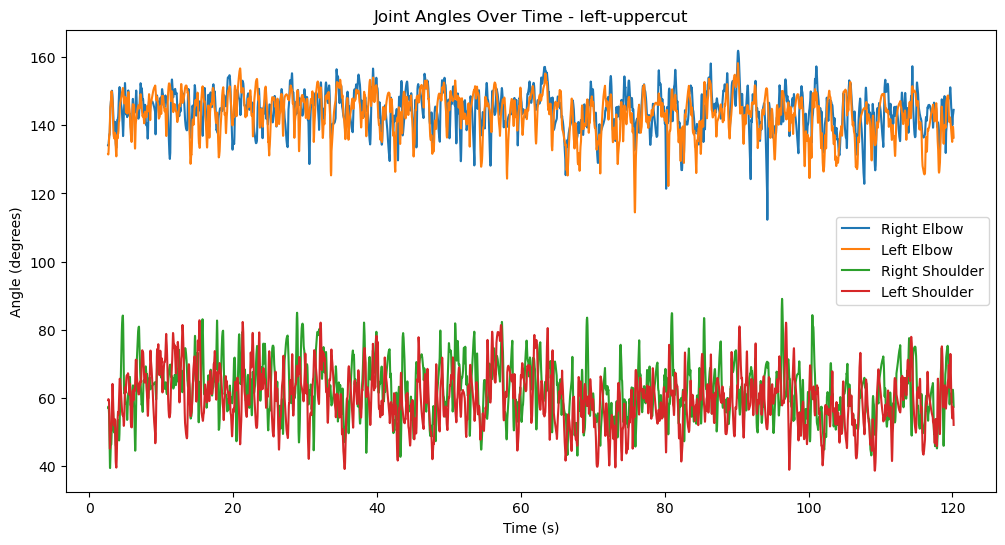

Plotting for boxing_data_no-punches_20241002_193049.csv - Movement Type: no-punches


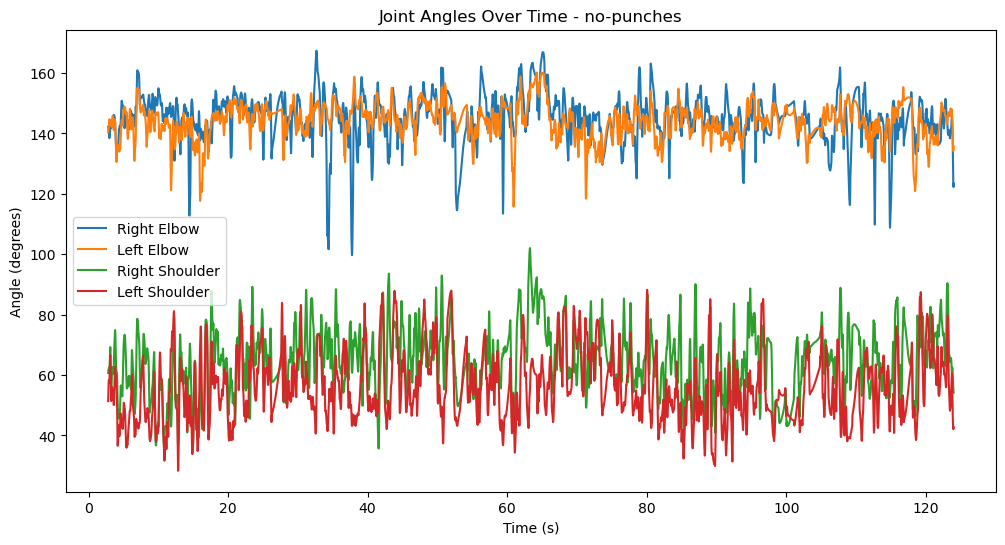

Plotting for boxing_data_right-hook_20241002_191701.csv - Movement Type: right-hook


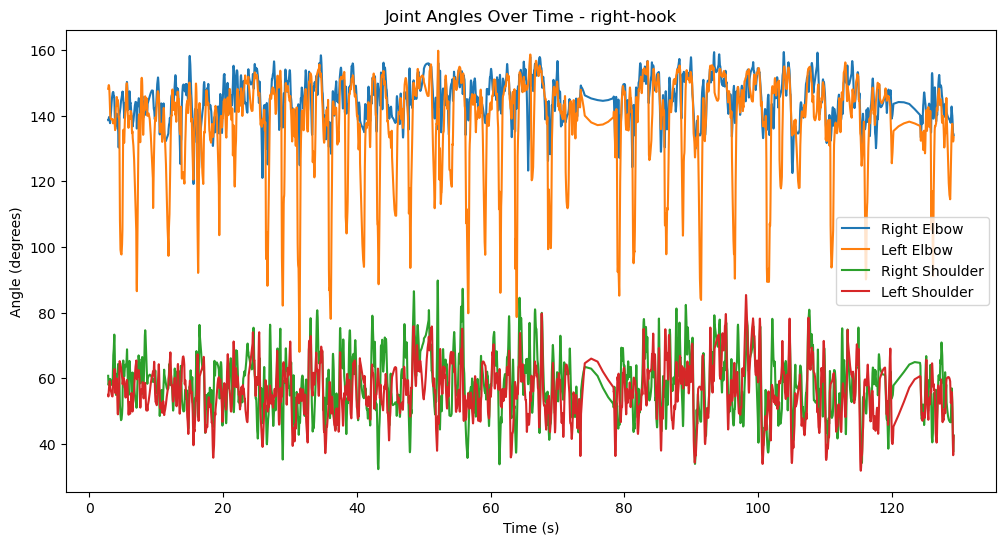

Plotting for boxing_data_right-uppercut_20241002_192607.csv - Movement Type: right-uppercut


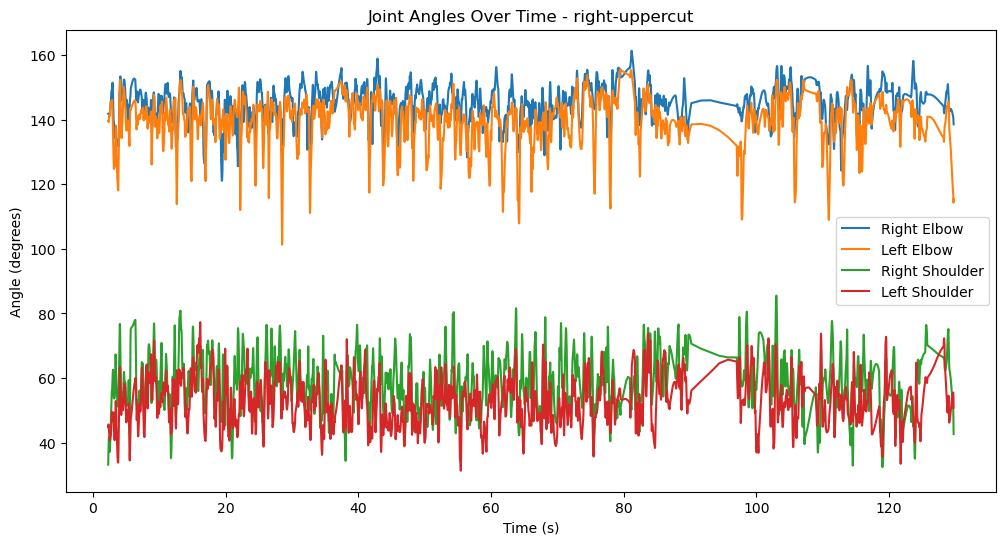

In [13]:
def plot_joint_angles(df, movement_type):
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['right_elbow_angle'], label='Right Elbow')
    plt.plot(df['timestamp'], df['left_elbow_angle'], label='Left Elbow')
    plt.plot(df['timestamp'], df['right_shoulder_angle'], label='Right Shoulder')
    plt.plot(df['timestamp'], df['left_shoulder_angle'], label='Left Shoulder')
    plt.title(f'Joint Angles Over Time - {movement_type}')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.show()
    
for file_name, df in cleaned_dfs.items():
    movement_type = df['movement_type'].iloc[0]
    print(f"Plotting for {file_name} - Movement Type: {movement_type}")
    plot_joint_angles(df, movement_type)

## Save Cleaned Data

In [ ]:
output_dir = '../data/cleaned'
os.makedirs(output_dir, exist_ok=True)
for file_name, df in cleaned_dfs.items():
    output_path(os.path.join(output_dir, f"cleaned_{file_name}"))